In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
/kaggle/input/00-customer-churn-preprocessing/__results__.html
/kaggle/input/00-customer-churn-preprocessing/__notebook__.ipynb
/kaggle/input/00-customer-churn-preprocessing/__output__.json
/kaggle/input/00-customer-churn-preprocessing/custom.css
/kaggle/input/00-customer-churn-preprocessing/__results___files/__results___11_0.png
/kaggle/input/00-customer-churn-preprocessing/__results___files/__results___17_0.png
/kaggle/input/00-customer-churn-preprocessing/__results___files/__results___18_0.png
/kaggle/input/00-customer-churn-preprocessing/__results___files/__results___7_0.png
/kaggle/input/00-customer-churn-preprocessing/figures/features_1.png
/kaggle/input/00-customer-churn-preprocessing/figures/features_2.png
/kaggle/input/00-customer-churn-preprocessing/figures/churn_dist.png
/kaggle/input/00-customer-churn-preprocessing/figures/features_3.png
/kaggle/input/00-customer-churn-preprocessing/processed/orig.csv
/

In [2]:
df = pd.read_csv('/kaggle/input/00-customer-churn-preprocessing/processed/processed.csv')
df.head()

,Unnamed: 0,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,0,No phone service,DSL,No,Yes,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,No,No,34,1,No,DSL,Yes,No,Yes,No,One year,0,Mailed check,56.95,1889.50,0
2,2,No,No,2,1,No,DSL,Yes,Yes,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,3,No,No,45,0,No phone service,DSL,Yes,No,Yes,Yes,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,4,No,No,2,1,No,Fiber optic,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [3]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Unnamed: 0,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,...,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,29.85,29.85,0,True,False,True,...,True,False,False,False,False,False,False,False,True,False
1,1,34,1,0,56.95,1889.50,0,False,False,False,...,False,False,True,False,False,True,False,False,False,True
2,2,2,1,1,53.85,108.15,1,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,3,45,0,0,42.30,1840.75,0,False,False,True,...,False,False,True,False,True,True,False,False,False,False
4,4,2,1,1,70.70,151.65,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False


> **As splitted in the baseline model, the dataset is splitted into training and test sets with an 80/20 ratio, ensuring that the target variable’s distribution remains consistent across both sets.**

In [4]:
X = df.drop(['Churn', 'Unnamed: 0'], axis=1)
y = df['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
print(X_train.shape, X_test.shape)

(5634, 24) (1409, 24)


> **Created a function called "evaluate_model" to easily apply and efficiently evaluate the model performances.**

In [6]:
from sklearn.base import clone
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(prefix, model, X_train, X_test, y_train, y_true, plot_cm=True):
    est = clone(model)
    est.fit(X_train, y_train)
    preds = est.predict(X_test)

    # get the AUC only for probability models
    try:
        y_score = preds.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_true, y_pred_proba)
    except:
        y_score = None
        auc = None

    accuracy = accuracy_score(y_true, preds)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, preds, average='binary')

    # print the result
    print(f"{prefix} Results:")
    print("-------------")
    print(f"Accuracy:{accuracy:.4f} | Precision:{precision:.4f} | Recall:{recall:.4f} | F1-score:{f1_score:.4f}")
    if auc is not None:
        print(f"ROC-AUC: {auc:.4f}")

    print("-------------")

    print("Classification Report:\n")
    print(classification_report(y_true, preds, digits=4))

    cm = confusion_matrix(y_true, preds)
    print("-------------")

    print("\nConfusion Matrix:\n", cm)

    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='.0f',
                    xticklabels=['No Churn', 'Churn'],
                    yticklabels=['No Churn', 'Churn'])
        plt.title(f"{prefix} Confusion Matrix", fontsize=16)
        plt.xlabel("Predicted", fontsize=12)
        plt.ylabel("True", fontsize=12)


        figure_title = f"heatmap_{prefix}.png"
        path = "/kaggle/working/figures/"
        os.makedirs(path, exist_ok=True)
        plt.tick_params(axis='both', labelsize=14)
        plt.tight_layout()
        plt.savefig(path+figure_title, dpi=200, bbox_inches='tight')
        plt.show()


<h1>1. Random Forest</h1>

In [7]:
from sklearn.ensemble import RandomForestClassifier

def build_rf():
    return RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )

RandomForest Results:
-------------
Accuracy:0.7793 | Precision:0.5763 | Recall:0.6364 | F1-score:0.6048
-------------
Classification Report:

              precision    recall  f1-score   support

           0     0.8635    0.8309    0.8469      1035
           1     0.5763    0.6364    0.6048       374

    accuracy                         0.7793      1409
   macro avg     0.7199    0.7336    0.7259      1409
weighted avg     0.7872    0.7793    0.7826      1409

-------------

Confusion Matrix:
 [[860 175]
 [136 238]]


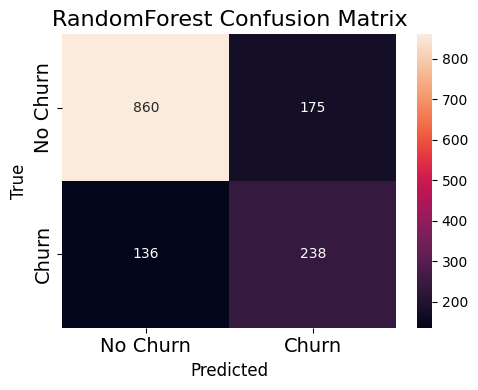

In [8]:
rf_est = build_rf()
evaluate_model('RandomForest', rf_est, X_train, X_test, y_train, y_test, plot_cm=True)

<h1>2. XGBoost</h1>

In [9]:
import xgboost as xgb

# calculate class imbalance ratio by counting pos/neg in the training set
pos = y_train.sum()
neg = len(y_train)-pos
scale_pos = neg/pos if pos>0 else 1.0

def build_xgb():
    return xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.08,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        objective='binary:logistic',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos,
        eval_metric='logloss',
        tree_method = "hist",
        device = "cuda"
    )

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:03:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
-------------
Accuracy:0.7679 | Precision:0.5575 | Recall:0.6096 | F1-score:0.5824
-------------
Classification Report:

              precision    recall  f1-score   support

           0     0.8540    0.8251    0.8393      1035
           1     0.5575    0.6096    0.5824       374

    accuracy                         0.7679      1409
   macro avg     0.7057    0.7174    0.7108      1409
weighted avg     0.7753    0.7679    0.7711      1409

-------------

Confusion Matrix:
 [[854 181]
 [146 228]]


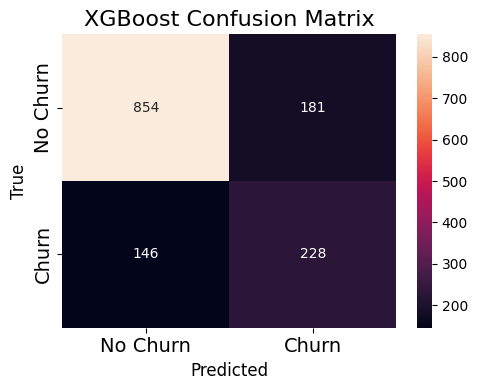

In [10]:
xgb_est = build_xgb()
evaluate_model("XGBoost", xgb_est, X_train, X_test, y_train, y_test, plot_cm=True)

<h1>3. LightGBM</h1>

In [11]:
from lightgbm import LGBMClassifier

def build_lgb():
    return LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.08,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        objective='binary',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos,
        device = "gpu"
    )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 24
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (0.09 MB) transferred to GPU in 0.001330 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
LightGBM Results:
-------------
Accuracy:0.7800 | Precision:0.5773 | Recall:0.6390 | F1-score:0.6066
-------------
Classification Report:

              precision    recall  f1-score   support

           0     0.8643    0.8309    0.8473      1035
           1     0.5773    0.6390    0.6066       374

    accuracy                         0.7800      1409
   macro avg     0.7208    0.7350    0.7269      1409
weighted avg     0.7881    0.7800    0.7834      1409

-------------

Confusion Matrix:
 [[860 175]
 [135 239]]


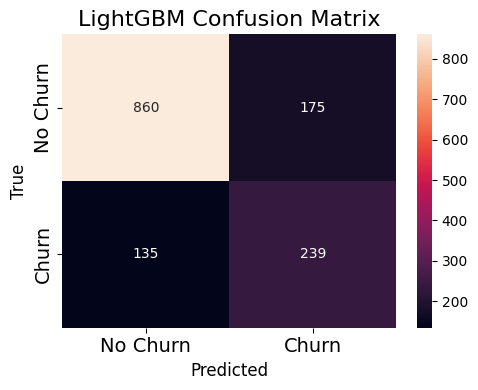

In [12]:
lgb = build_lgb()
evaluate_model("LightGBM", lgb, X_train, X_test, y_train, y_test, plot_cm=True)

<h1>4. Grid Search + RF & Grid Search + XGBoost</h1>


In [13]:
rf_grid = RandomForestClassifier(
    max_depth=None,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

param_grid_rf = {
    "n_estimators":[400, 700, 1000],
    "min_samples_split":[2, 4],
    "min_samples_leaf":[1, 2, 4],
    "class_weight":["balanced_subsample", None]
}

In [14]:
from sklearn.model_selection import GridSearchCV

grid_search_rf = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

In [15]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [400, 700, 1000]},
             scoring='roc_auc')

In [16]:
print(f"Best Parameters of RF: {grid_search_rf.best_params_}")
print(f"Best Score (ROC-AUC) of RF: {grid_search_rf.best_score_}")

Best Parameters of RF: {'class_weight': 'balanced_subsample', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
Best Score (ROC-AUC) of RF: 0.8431130320258013


In [17]:
best_rf = grid_search_rf.best_estimator_
best_rf_y_pred = best_rf.predict(X_test)

Classification Report:

              precision    recall  f1-score   support

           0     0.8839    0.7874    0.8329      1035
           1     0.5483    0.7139    0.6202       374

    accuracy                         0.7679      1409
   macro avg     0.7161    0.7507    0.7266      1409
weighted avg     0.7948    0.7679    0.7764      1409

-----

Confusion Matrix:
 [[815 220]
 [107 267]]


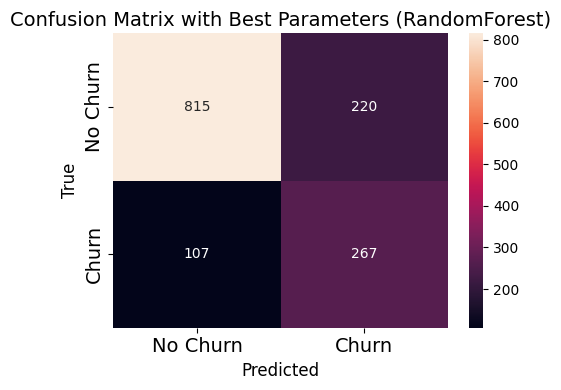

In [18]:
best_rf_cm = confusion_matrix(y_test, best_rf_y_pred)
print("Classification Report:\n")
print(classification_report(y_test, best_rf_y_pred, digits=4))

print("-----")

print("\nConfusion Matrix:\n", best_rf_cm)

plt.figure(figsize=(5, 4))
sns.heatmap(best_rf_cm, annot=True, fmt='.0f',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix with Best Parameters (RandomForest)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)


figure_title = "rf_best_param.png"
path = "/kaggle/working/figures/"
os.makedirs(path, exist_ok=True)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig(path+figure_title, dpi=200, bbox_inches='tight')
plt.show()

In [19]:
xgb_grid = xgb.XGBClassifier(
    learning_rate=0.08,
    reg_lambda=1,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    tree_method = "hist",
    device = "cuda"
)

param_grid_xgb = {
    "n_estimators":[500, 1000],
    "max_depth":[6, None],
    "min_child_weight":[1, 3],
    "subsample":[0.8, 1.0],
    "colsample_bytree":[0.8, 1.0]
}

In [20]:
grid_search_xgb = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

In [21]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

X_train_opt = X_train.astype('float32') if hasattr(X_train, 'astype') else X_train
y_train_opt = y_train.astype('float32') if hasattr(y_train, 'astype') else y_train
grid_search_xgb.fit(X_train_opt, y_train_opt)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:08:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:08:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rat...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'max_depth': [6, None],
                         'min_child_weight': [1, 3],
                         'n_estimators': [500, 1000], 'subsample': [0.8, 1.0]},
             scoring='roc_auc')

In [22]:
print(f"Best Parameters of XGboost: {grid_search_xgb.best_params_}")
print(f"Best Score (ROC-AUC) of XGboost: {grid_search_xgb.best_score_}")

Best Parameters of XGboost: {'colsample_bytree': 0.8, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 1.0}
Best Score (ROC-AUC) of XGboost: 0.8231322146026832


In [23]:
best_xgb = grid_search_xgb.best_estimator_
best_xgb_y_pred = best_xgb.predict(X_test)

Classification Report:

              precision    recall  f1-score   support

           0     0.8620    0.7903    0.8246      1035
           1     0.5283    0.6497    0.5827       374

    accuracy                         0.7530      1409
   macro avg     0.6951    0.7200    0.7037      1409
weighted avg     0.7734    0.7530    0.7604      1409

-----

Confusion Matrix:
 [[818 217]
 [131 243]]


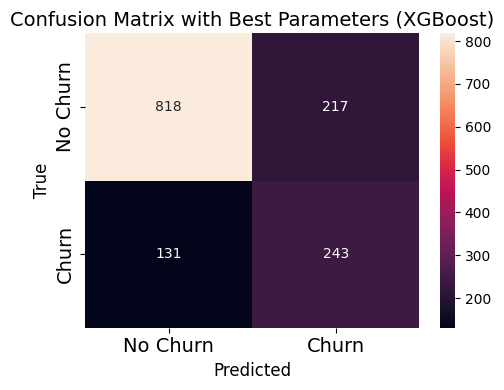

In [24]:
best_xgb_cm = confusion_matrix(y_test, best_xgb_y_pred)
print("Classification Report:\n")
print(classification_report(y_test, best_xgb_y_pred, digits=4))

print("-----")
print("\nConfusion Matrix:\n", best_xgb_cm)

plt.figure(figsize=(5, 4))
sns.heatmap(best_xgb_cm, annot=True, fmt='.0f',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix with Best Parameters (XGBoost)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)


figure_title = "xgb_best_param.png"
path = "/kaggle/working/figures/"
os.makedirs(path, exist_ok=True)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig(path+figure_title, dpi=200, bbox_inches='tight')
plt.show()

<h1>5. Feature Importances</h1>

In [25]:
importances_rf = best_rf.feature_importances_
importances_xgb = best_xgb.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance by RF': importances_rf,
    'Importance by XGB': importances_xgb
}).sort_values(by='Feature', ascending=False).reset_index(drop=True)

feature_importance

,Feature,Importance by RF,Importance by XGB
0,tenure,0.182901,0.025214
1,TotalCharges,0.161943,0.014281
2,TechSupport_Yes,0.026216,0.014637
3,TechSupport_No internet service,0.019913,0.000000
4,PhoneService,0.004397,0.015385
5,PaymentMethod_Mailed check,0.009064,0.011296
6,PaymentMethod_Electronic check,0.050247,0.016802
7,PaymentMethod_Credit card (automatic),0.011771,0.012497
8,Partner_Yes,0.014995,0.009811
9,PaperlessBilling,0.022370,0.014399


In [26]:
os.makedirs("/kaggle/working/outdata", exist_ok=True)
feature_importance.to_csv("outdata/feature_importance.csv")

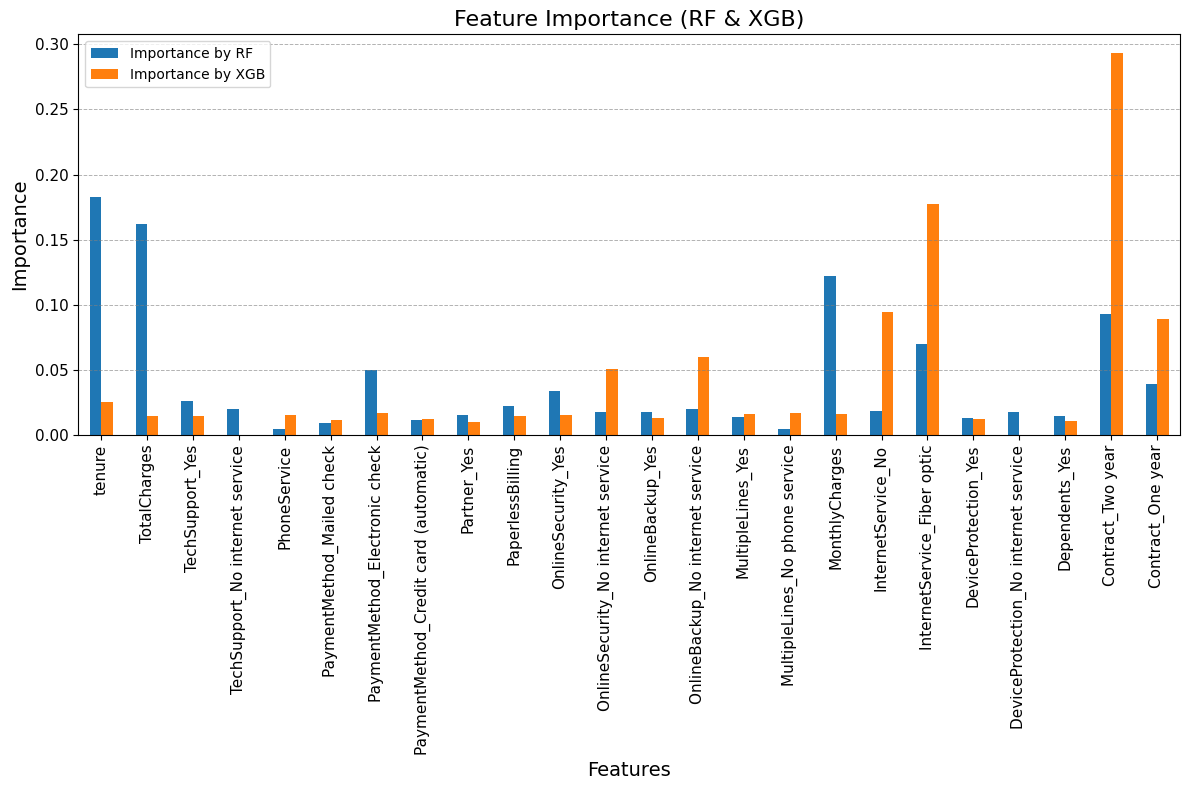

In [27]:
feature_importance.plot(
    x='Feature',
    y=['Importance by RF', 'Importance by XGB'],
    kind='bar',
    figsize=(12,8),
    rot=90,
    fontsize=11
)
plt.title("Feature Importance (RF & XGB)", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6, axis='y', which='both')
plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=200, bbox_inches='tight')
plt.show()